In [15]:
import copy
import json
from itertools import product
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

# 复合块的最小填充率
fill_rate = 0.9
area_rate = 0.5 #因为没有稳定性约束，可以不要(可放置矩形顶部的面积比值)
max_times = 2# 复合块最大复杂度
max_depth= 3#树的最大搜索深度
max_branch = 2#搜索的分支节点数
tmp_best_ps = None# 临时的最优放置方案

dimensions=[]#存放箱体坐标

# 栈数据结构，用于存储剩余空间
class Stack:
    def __init__(self):
        self.data = []

    def empty(self):
        return len(self.data) == 0

    def not_empty(self):
        return len(self.data) > 0

    def pop(self):
        return self.data.pop() if len(self.data) > 0 else None

    def push(self, *items):
        for item in items:
            self.data.append(item)

    def top(self):
        return self.data[len(self.data) - 1] if len(self.data) > 0 else None

    def clear(self):
        self.data.clear()

    def size(self):
        return len(self.data)


# 箱子类
class Box:
    def __init__(self, lx, ly, lz, type=0):
        # 长
        self.lx = lx
        # 宽
        self.ly = ly
        # 高
        self.lz = lz
        # 类型
        self.type = type

    def __str__(self):
        return "lx: {}, ly: {}, lz: {}, type: {}".format(self.lx, self.ly, self.lz, self.type)


# 剩余空间类
class Space:
    def __init__(self, x, y, z, lx, ly, lz, origin=None):
        # 坐标
        self.x = x
        self.y = y
        self.z = z
        # 长
        self.lx = lx
        # 宽
        self.ly = ly
        # 高
        self.lz = lz
        # 表示从哪个剩余空间切割而来
        self.origin = origin

    def __str__(self):
        return "x:{},y:{},z:{},lx:{},ly:{},lz:{}".format(self.x, self.y, self.z, self.lx, self.ly, self.lz)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y and self.z == other.z and self.lx == other.lx and self.ly == other.ly and self.lz == other.lz


# 装箱问题类
class Problem:
    def __init__(self, container: Space, box_list=[], num_list=[]):
        # 容器
        self.container = container
        # 箱子列表
        self.box_list = box_list
        # 箱子对应的数量
        self.num_list = num_list


# 块类
class Block:
    def __init__(self, lx, ly, lz, require_list=[], children=[], direction=None):
        # 长
        self.lx = lx
        # 宽
        self.ly = ly
        # 高
        self.lz = lz
        # 需要的物品数量
        self.require_list = require_list
        # 体积
        self.volume = 0
        # 子块列表，简单块的子块列表为空
        self.children = children
        # 复合块子块的合并方向
        self.direction = direction
        # 顶部可放置矩形尺寸
        self.ax = 0
        self.ay = 0
        # 复杂度，复合次数
        self.times = 0
        # 适应度，块选择时使用
        self.fitness = 0

    def __str__(self):
        return "lx: %s, ly: %s, lz: %s, volume: %s, ax: %s, ay: %s, times:%s, fitness: %s, require: %s, children: " \
               "%s, direction: %s" % (self.lx, self.ly, self.lz, self.volume, self.ax, self.ay, self.times, self.fitness, self.require_list, self.children, self.direction)

    def __eq__(self, other):
        return self.lx == other.lx and self.ly == other.ly and self.lz == other.lz and self.ax == other.ax and self.ay == self.ay and (np.array(self.require_list) == np.array(other.require_list)).all()

    def __hash__(self):
        return hash(",".join([str(self.lx), str(self.ly), str(self.lz), str(self.ax), str(self.ay), ",".join([str(r) for r in self.require_list])]))


# 放置类
class Place:
    def __init__(self, space: Space, block: Block):
        # 空间
        self.space = space
        # 块
        self.block = block

    def __eq__(self, other):
        return self.space == other.space and self.block == other.block


# 装箱状态类
class PackingState:
    def __init__(self, plan_list=[], space_stack: Stack = Stack(), avail_list=[]):
        # 已生成的装箱方案列表
        self.plan_list = plan_list
        # 剩余空间堆栈
        self.space_stack = space_stack
        # 剩余可用箱体数量
        self.avail_list = avail_list
        # 已装载物品总体积
        self.volume = 0
        # 最终装载物品的总体积的评估值
        self.volume_complete = 0


# 合并块时通用校验项目
def combine_common_check(combine: Block, container: Space, num_list):
    # 合共块尺寸不得大于容器尺寸
    if combine.lx > container.lx:
        return False
    if combine.ly > container.ly:
        return False
    if combine.lz > container.lz:
        return False
    # 合共块需要的箱子数量不得大于箱子总的数量
    if (np.array(combine.require_list) > np.array(num_list)).any():
        return False
    # 合并块的填充体积不得小于最小填充率
    if combine.volume / (combine.lx * combine.ly * combine.lz) < fill_rate:
        return False
    # 合并块的顶部可放置矩形必须足够大
    if (combine.ax * combine.ay) / (combine.lx * combine.ly) < area_rate:
        return False
    # 合并块的复杂度不得超过最大复杂度
    if combine.times > max_times:
        return False
    return True


# 合并块时通用合并项目
def combine_common(a: Block, b: Block, combine: Block):
    # 合并块的需求箱子数量
    combine.require_list = (np.array(a.require_list) + np.array(b.require_list)).tolist()
    # 合并填充体积
    combine.volume = a.volume + b.volume
    # 构建父子关系
    combine.children = [a, b]
    # 合并后的复杂度
    combine.times = max(a.times, b.times) + 1


# 生成简单块
def gen_simple_block(container, box_list, num_list):
    block_table = []
    for box in box_list:
        for nx in np.arange(num_list[box.type]) + 1:
            for ny in np.arange(num_list[box.type] / nx) + 1:
                for nz in np.arange(num_list[box.type] / nx / ny) + 1:
                    if box.lx * nx <= container.lx and box.ly * ny <= container.ly and box.lz * nz <= container.lz:
                        # 该简单块需要的立体箱子数量
                        requires = np.full_like(num_list, 0)
                        requires[box.type] = nx * ny * nz
                        # 简单块
                        block = Block(box.lx * nx, box.ly * ny, box.lz * nz, requires)
                        # 顶部可放置矩形
                        block.ax = box.lx * nx
                        block.ay = box.ly * ny
                        # 简单块填充体积
                        block.volume = box.lx * nx * box.ly * ny * box.lz * nz
                        # 简单块复杂度
                        block.times = 0
                        block_table.append(block)
    return sorted(block_table, key=lambda x: x.volume, reverse=True)


# 生成复合块
def gen_complex_block(container, box_list, num_list):
    # 先生成简单块
    block_table = gen_simple_block(container, box_list, num_list)
    for times in range(max_times):
        new_block_table = []
        # 循环所有简单块，两两配对
        for i in np.arange(0, len(block_table)):
            # 第一个简单块
            a = block_table[i]
            for j in np.arange(0, len(block_table)):
                # 简单块不跟自己复合
                if j == i:
                    continue
                # 第二个简单块
                b = block_table[j]
                # 复杂度满足当前复杂度
                if a.times == times or b.times == times:
                    c = Block(0, 0, 0)
                    # 按x轴方向复合
                    if a.ax == a.lx and b.ax == b.lx and a.lz == b.lz:
                        c.direction = "x"
                        c.ax = a.ax + b.ax
                        c.ay = min(a.ay, b.ay)
                        c.lx = a.lx + b.lx
                        c.ly = max(a.ly, b.ly)
                        c.lz = a.lz
                        combine_common(a, b, c)
                        if combine_common_check(c, container, num_list):
                            new_block_table.append(c)
                            continue
                    # 按y轴方向复合
                    if a.ay == a.ly and b.ay == b.ly and a.lz == b.lz:
                        c.direction = "y"
                        c.ax = min(a.ax, b.ax)
                        c.ay = a.ay + b.ay
                        c.lx = max(a.lx, b.lx)
                        c.ly = a.ly + b.ly
                        c.lz = a.lz
                        combine_common(a, b, c)
                        if combine_common_check(c, container, num_list):
                            new_block_table.append(c)
                            continue
                    # 按z轴方向复合
                    if a.ax >= b.lx and a.ay >= b.ly:
                        c.direction = "z"
                        c.ax = b.ax
                        c.ay = b.ay
                        c.lx = a.lx
                        c.ly = a.ly
                        c.lz = a.lz + b.lz
                        combine_common(a, b, c)
                        if combine_common_check(c, container, num_list):
                            new_block_table.append(c)
                            continue
        # 加入新生成的复合块
        block_table = block_table + new_block_table
        # 去重，拥有相同三边长度、物品需求和顶部可放置矩形的复合块被视为等价块，重复生成的等价块将被忽略
        block_table = list(set(block_table))
    # 按填充体积对复合块进行排序
    return sorted(block_table, key=lambda x: x.volume, reverse=True)


# 生成可行块列表
def gen_block_list(space: Space, avail, block_table):
    block_list = []
    for block in block_table:
        # 块中需要的箱子需求数量必须小于当前待装箱的箱子数量
        # 块的尺寸必须小于放置空间尺寸
        if (np.array(block.require_list) <= np.array(avail)).all() and \
                block.lx <= space.lx and block.ly <= space.ly and block.lz <= space.lz:
            block_list.append(block)
    return block_list


# 裁切出新的剩余空间（有稳定性约束）
def gen_residual_space(space: Space, block: Block, box_list=[]):
    # 三个维度的剩余尺寸
    rmx = space.lx - block.lx
    rmy = space.ly - block.ly
    rmz = space.lz - block.lz
    # 三个新裁切出的剩余空间（按入栈顺序依次返回）
    if rmx >= rmy:
        # 可转移空间归属于x轴切割空间
        drs_x = Space(space.x + block.lx, space.y, space.z, rmx, space.ly, space.lz, space)
        drs_y = Space(space.x, space.y + block.ly, space.z, block.lx, rmy, space.lz, space)
        drs_z = Space(space.x, space.y, space.z + block.lz, block.ax, block.ay, rmz, None)
        return drs_z, drs_y, drs_x
    else:
        # 可转移空间归属于y轴切割空间
        drs_x = Space(space.x + block.lx, space.y, space.z, rmx, block.ly, space.lz, space)
        drs_y = Space(space.x, space.y + block.ly, space.z, space.lx, rmy, space.lz, space)
        drs_z = Space(space.x, space.y, space.z + block.lz, block.ax, block.ay, rmz, None)
        return drs_z, drs_x, drs_y


# 空间转移
def transfer_space(space: Space, space_stack: Stack):
    # 仅剩一个空间的话，直接弹出
    if space_stack.size() <= 1:
        space_stack.pop()
        return None
    # 待转移空间的原始空间
    discard = space
    # 目标空间
    space_stack.pop()
    target = space_stack.top()
    # 将可转移的空间转移给目标空间
    if discard.origin is not None and target.origin is not None and discard.origin == target.origin:
        new_target = copy.deepcopy(target)
        # 可转移空间原先归属于y轴切割空间的情况
        if discard.lx == discard.origin.lx:
            new_target.ly = discard.origin.ly
        # 可转移空间原来归属于x轴切割空间的情况
        elif discard.ly == discard.origin.ly:
            new_target.lx = discard.origin.lx
        else:
            return None
        space_stack.pop()
        space_stack.push(new_target)
        # 返回未发生转移之前的目标空间
        return target
    return None


# 还原空间转移
def transfer_space_back(space: Space, space_stack: Stack, revert_space: Space):
    space_stack.pop()
    space_stack.push(revert_space)
    space_stack.push(space)


# 块放置算法
def place_block(ps: PackingState, block: Block):
    # 栈顶剩余空间
    space = ps.space_stack.pop()
    # 更新可用箱体数目
    ps.avail_list = (np.array(ps.avail_list) - np.array(block.require_list)).tolist()
    # 更新放置计划
    place = Place(space, block)
    ps.plan_list.append(place)
    # 更新体积利用率
    ps.volume = ps.volume + block.volume
    # 压入新的剩余空间
    cuboid1, cuboid2, cuboid3 = gen_residual_space(space, block)
    ps.space_stack.push(cuboid1, cuboid2, cuboid3)
    # 返回临时生成的放置
    return place


# 块移除算法
def remove_block(ps: PackingState, block: Block, place: Place, space: Space):
    # 还原可用箱体数目
    ps.avail_list = (np.array(ps.avail_list) + np.array(block.require_list)).tolist()
    # 还原排样计划
    ps.plan_list.remove(place)
    # 还原体积利用率
    ps.volume = ps.volume - block.volume
    # 移除在此之前裁切出的新空间
    for _ in range(3):
        ps.space_stack.pop()
    # 还原之前的空间
    ps.space_stack.push(space)


# 补全放置方案
def complete(ps: PackingState, block_table):
    # 不对当前的放置状态进行修改
    tmp = copy.deepcopy(ps)
    while tmp.space_stack.not_empty():
        # 栈顶空间
        space = tmp.space_stack.top()
        # 可用块列表
        block_list = gen_block_list(space, ps.avail_list, block_table)
        if len(block_list) > 0:
            # 放置块
            place_block(tmp, block_list[0])
        else:
            # 空间转移
            transfer_space(space, tmp.space_stack)
    # 补全后的使用体积
    ps.volume_complete = tmp.volume


# 带深度限制的深度优先搜索算法
def depth_first_search(ps: PackingState, depth, branch, block_table):
    global tmp_best_ps
    if depth != 0:
        space = ps.space_stack.top()
        block_list = gen_block_list(space, ps.avail_list, block_table)
        if len(block_list) > 0:
            # 遍历所有分支
            for i in range(min(branch, len(block_list))):
                # 放置块
                place = place_block(ps, block_list[i])
                # 放置下一个块
                depth_first_search(ps, depth - 1, branch, block_table)
                # 移除刚才添加的块
                remove_block(ps, block_list[i], place, space)
        else:
            # 转移空间
            old_target = transfer_space(space, ps.space_stack)
            if old_target:
                # 放置下一个块
                depth_first_search(ps, depth, branch, block_table)
                # 还原转移空间
                transfer_space_back(space, ps.space_stack, old_target)
    else:
        # 补全该方案
        complete(ps, block_table)
        # 更新最优解
        if ps.volume_complete > tmp_best_ps.volume_complete:
            tmp_best_ps = copy.deepcopy(ps)


# 评价某个块
def estimate(ps: PackingState, block_table, search_params):
    # 空的放置方案
    global tmp_best_ps
    # tmp_best_ps = PackingState()
    tmp_best_ps = PackingState([], Stack(), [])
    # 开始深度优先搜索
    depth_first_search(ps, max_depth, max_branch, block_table)
    return tmp_best_ps.volume_complete


# 查找下一个可行块
def find_next_block(ps: PackingState, block_list, block_table, search_params):
    # 最优适应度
    best_fitness = 0
    # 初始化最优块为第一个块（填充体积最大的块）
    best_block = block_list[0]
    # 遍历所有可行块
    for block in block_list:
        # 栈顶空间
        space = ps.space_stack.top()
        # 放置块
        place = place_block(ps, block)
        # 评价值
        fitness = estimate(ps, block_table, search_params)
        # 移除刚才添加的块
        remove_block(ps, block, place, space)
        # 更新最优解
        if fitness > best_fitness:
            best_fitness = fitness
            best_block = block

    # return best_block
    # # 也可以采用贪心算法，直接返回填充体积最大的块
    return block_list[0]


# 递归构建箱体坐标，用于绘图
def build_box_position(block, init_pos, box_list):
    # 遇到简单块时进行坐标计算
    if len(block.children) <= 0 and block.times == 0:
        # 箱体类型索引
        box_idx = (np.array(block.require_list) > 0).tolist().index(True)
        if box_idx > -1:
            # 所需箱体
            box = box_list[box_idx]
            # 箱体的相对坐标
            nx = block.lx / box.lx
            ny = block.ly / box.ly
            nz = block.lz / box.lz
            x_list = (np.arange(0, nx) * box.lx).tolist()
            y_list = (np.arange(0, ny) * box.ly).tolist()
            z_list = (np.arange(0, nz) * box.lz).tolist()
            # 箱体的绝对坐标
            dimension = (np.array([x for x in product(x_list, y_list, z_list)]) + np.array([init_pos[0], init_pos[1], init_pos[2]])).tolist()
            # print("绝对坐标：",dimensions,len(dimensions))
            global dimensions
            dimensions.append(dimension)
            return sorted([d + [box.lx, box.ly, box.lz] for d in dimension], key=lambda x: (x[0], x[1], x[2]))
        return []

    pos = []
    for child in block.children:
        pos += build_box_position(child, (init_pos[0], init_pos[1], init_pos[2]), box_list)
        # 根据子块的复合方向，确定下一个子块的左后下角坐标
        if block.direction == "x":
            init_pos = (init_pos[0] + child.lx, init_pos[1], init_pos[2])
        elif block.direction == "y":
            init_pos = (init_pos[0], init_pos[1] + child.ly, init_pos[2])
        elif block.direction == "z":
            init_pos = (init_pos[0], init_pos[1], init_pos[2] + child.lz)
    return pos


# 绘制立方体边框
def plot_linear_cube(ax, x, y, z, dx, dy, dz, color='white', linestyle=None):
    xx = [x, x, x+dx, x+dx, x]
    yy = [y, y+dy, y+dy, y, y]
    kwargs = {"alpha": 1, "color": color, "linewidth": 2.5, "zorder": 2}
    if linestyle:
        kwargs["linestyle"] = linestyle
    ax.plot3D(xx, yy, [z]*5, **kwargs)
    ax.plot3D(xx, yy, [z+dz]*5, **kwargs)
    ax.plot3D([x, x], [y, y], [z, z+dz], **kwargs)
    ax.plot3D([x, x], [y+dy, y+dy], [z, z+dz], **kwargs)
    ax.plot3D([x+dx, x+dx], [y+dy, y+dy], [z, z+dz], **kwargs)
    ax.plot3D([x+dx, x+dx], [y, y], [z, z+dz], **kwargs)


# 立方体
def cuboid_data2(o, size=(1, 1, 1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:, :, i] *= size[i]
    X += np.array(o)
    return X


# 绘制立方体
def plotCubeAt2(positions, sizes=None, colors=None, **kwargs):
    if not isinstance(colors, (list, np.ndarray)):
        colors = ["C0"] * len(positions)
    if not isinstance(sizes, (list, np.ndarray)):
        sizes = [(1, 1, 1)] * len(positions)
    g = []
    for p, s, c in zip(positions, sizes, colors):
        g.append(cuboid_data2(p, size=s))
    return Poly3DCollection(np.concatenate(g), facecolors=np.repeat(colors, 6), **kwargs)


# 绘制排样结果
def draw_packing_result(problem: Problem, ps: PackingState,box_type):
    # 绘制结果
    fig = plt.figure()
    ax1 = mplot3d.Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax1)
    # 绘制容器
    plot_linear_cube(ax1, 0, 0, 0, problem.container.lx, problem.container.ly, problem.container.lz)
    for p in ps.plan_list:
        # 箱子位置及尺寸
        box_pos = build_box_position(p.block, (p.space.x, p.space.y, p.space.z), problem.box_list)
        positions = []
        sizes = []
        # 箱子颜色
        colors = ["yellow"] * len(box_pos)
        for bp in sorted(box_pos, key=lambda x: (x[0], x[1], x[2])):
            positions.append((bp[0], bp[1], bp[2]))
            sizes.append((bp[3], bp[4], bp[5]))
        pc = plotCubeAt2(positions, sizes, colors=colors, edgecolor="k")
        ax1.add_collection3d(pc)
    plt.title('PackingResult for {}'.format(box_type))
    plt.savefig("./pictures/{}.jpg".format(box_type),bbox_inches='tight',dpi=800)
    plt.show()
    
    


# 基本启发式算法
def basic_heuristic(is_complex, search_params, problem: Problem,box_type,id):
    if is_complex:
        # 生成复合块
        block_table = gen_complex_block(problem.container, problem.box_list, problem.num_list)
    else:
        # 生成简单块
        block_table = gen_simple_block(problem.container, problem.box_list, problem.num_list)
    # 初始化排样状态
    ps = PackingState(avail_list=problem.num_list)
    # 开始时，剩余空间堆栈中只有容器本身
    ps.space_stack.push(problem.container)
    # 所有剩余空间均转满，则停止
    while ps.space_stack.size() > 0:
        space = ps.space_stack.top()
        block_list = gen_block_list(space, ps.avail_list, block_table)
        if block_list:
            # 查找下一个近似最优块
            block = find_next_block(ps, block_list, block_table, search_params)
            # 弹出顶部剩余空间
            ps.space_stack.pop()
            # 更新可用物品数量
            ps.avail_list = (np.array(ps.avail_list) - np.array(block.require_list)).tolist()
            # 更新排样计划
            ps.plan_list.append(Place(space, block))
            # 更新已利用体积
            ps.volume = ps.volume + block.volume
            # 压入新裁切的剩余空间
            cuboid1, cuboid2, cuboid3 = gen_residual_space(space, block)
            ps.space_stack.push(cuboid1, cuboid2, cuboid3)
        else:
            # 转移剩余空间
            transfer_space(space, ps.space_stack)

    
    # print("已使用的容积",ps.volume)
    # print('利用率：',ps.volume/(problem.container.lx*problem.container.ly*problem.container.lz))

    info = {"箱体类型:":box_type,"已使用容积:":ps.volume,"以使用箱体的个数:":(np.array(problem.num_list)-np.array(ps.avail_list)).tolist(),
            "剩余箱体个数:":ps.avail_list,"利用率:":round(ps.volume/(problem.container.lx*problem.container.ly*problem.container.lz),3)
    }
    print(info)
    with open('./data/info.json','a',encoding='utf-8')as f:
        json.dump(info,f,ensure_ascii=False)
        f.write('\n')
    # 绘制排样结果图
    draw_packing_result(problem, ps,box_type)


# 主算法
def main():
    # 容器
    container = Space(0, 0, 0, 587, 233, 220)
    
    # 箱体列表及数量

    #3种箱子
    type3_box0,type3_num0 = [Box(108,76,30,0),Box(110,43,25,1),Box(92,81,55,2)],[40,33,39]#70%
    type3_box1,type3_num1 = [Box(91 ,54,45,0),Box(105 ,77 ,72,1),Box(79,78,48,2)],[32,24,30]
    type3_box2,type3_num2 = [Box(60 ,40 ,32,0),Box(98 ,75 ,55,1),Box(60, 59, 39,2)],[64,40,64]
    type3_box3,type3_num3 = [Box(78 ,37 ,27,0),Box(89 ,70 ,25,1),Box(90 ,84 ,41,2)],[63,52,55]
    box3_list = [type3_box0,type3_box1,type3_box2,type3_box3]
    num3_list = [type3_num0,type3_num1,type3_num2,type3_num3]
    


    #5种箱子
    type5_box0,type5_num0 = [Box(108 ,76 ,30,0),Box(110 ,43, 25,1),Box(92, 81, 55,2),Box(81, 33, 28,3),Box(120, 99, 73,4)],[24,7,22,13,15]
    type5_box1,type5_num1 = [Box(49 ,25 ,21,0),Box(60 ,51 ,41,1),Box(103 ,76 ,64,2),Box(95 ,70 ,62,3),Box(111 ,49 ,26,4)],[22,22,28,25,17]
    type5_box2,type5_num2 = [Box(88 ,54 ,39,0),Box(94 ,54 ,36,1),Box(87 ,77 ,43,2),Box(100 ,80 ,72,3),Box(83 ,40 ,36,4)],[25,27,21,20,24]
    type5_box3,type5_num3 = [Box(90 ,70 ,63,0),Box(84 ,78 ,28,1),Box(94 ,85 ,39,2),Box(80 ,76 ,54,3), Box(69 ,50 ,45,4)],[16,28,20,23,31]
    type5_box4,type5_num4 = [Box(74 ,63 ,61,0),Box(71 ,60 ,25,1),Box(106 ,80 ,59,2),Box(109 ,76 ,42,3),Box(118 ,56 ,22,4)],[22,12,25,24,11]
    box5_list=[type5_box0,type5_box1,type5_box2,type5_box3,type5_box4]
    num5_list = [type5_num0,type5_num1,type5_num2,type5_num3,type5_num4]
    
    #8种箱子
    type8_box0,type8_num0 = [Box(108 ,76 ,30 ,0),Box(110 ,43 ,25 ,1),Box(92 ,81 ,55 ,2),Box(81 ,33 ,28 ,3),Box(120 ,99 ,73 ,4),Box(111 ,70 ,48 ,5),Box(98 ,72 ,46 ,6),Box(95 ,66 ,31 ,7)],[24,9,8,11,11,10,12,9]
    type8_box1,type8_num1 = [Box(97 ,81 ,27 ,0),Box(102 ,78 ,39 ,1),Box(113 ,46 ,36 ,2),Box(66 ,50 ,42 ,3),Box(101 ,30 ,26 ,4),Box(100 ,56 ,35 ,5),Box(91 ,50 ,40 ,6),Box(106 ,61 ,56 ,7)],[10,20,18,21,16,17,22,19]
    type8_box2,type8_num2 = [Box(88 ,54 ,39 ,0),Box(94 ,54 ,36 ,1),Box(87 ,77 ,43 ,2),Box(100 ,80 ,72 ,3),Box(83 ,40 ,36 ,4),Box(91 ,54 ,22 ,5),Box(109 ,58 ,54 ,6),Box(94 ,55 ,30 ,7)],[16,14,20,16,6,15,17,9]
    type8_box3,type8_num3 = [Box(49 ,25 ,21 ,0),Box(60 ,51 ,41 ,1),Box(103 ,76 ,64 ,2),Box(95 ,70 ,62 ,3),Box(111 ,49 ,26 ,4),Box(85 ,84 ,72 ,5),Box(48 ,36 ,31 ,6),Box(86 ,76 ,38 ,7)],[16,8,16,18,18,16,17,6]
    type8_box4,type8_num4 = [Box(113 ,92 ,33 ,0),Box(52 ,37 ,28 ,1),Box(57 ,33 ,29 ,2),Box(99 ,37 ,30 ,3),Box(92 ,64 ,33 ,4),Box(119 ,59 ,39 ,5),Box(54 ,52 ,49 ,6),Box(75 ,45 ,35 ,7)],[23,22,26,17,23,26,18,30]
    box8_list = [type8_box0,type8_box1,type8_box2,type8_box3,type8_box4]
    num8_list = [type8_num0,type8_num1,type8_num2,type8_num3,type8_num4]

     #10种箱子
    type10_box0,type10_num0 = [Box(49 ,25 ,21 ,0),Box(60 ,51 ,41 ,1),Box(103 ,76 ,64 ,2),Box(95 ,70 ,62 ,3),Box(111 ,49 ,26 ,4),Box(85 ,84 ,72 ,5),Box(48 ,36 ,31 ,6),Box(86 ,76 ,38 ,7),Box(71 ,48 ,47 ,8),Box(90 ,43 ,33 ,9)],[13,9,11,14,13,16,12,11,16,8]
    type10_box1,type10_num1 = [Box(97 ,81 ,27 ,0),Box(102 ,78 ,39 ,1),Box(113 ,46 ,36 ,2),Box(66 ,50 ,42 ,3),Box(101 ,30 ,26 ,4),Box(100 ,56 ,35 ,5),Box(91 ,50 ,40 ,6),Box(106 ,61 ,56 ,7),Box(103 ,63 ,58 ,8),Box(75 ,57 ,41 ,9)],[8,16,12,12,18,13,14,17,12,13]
    type10_box2,type10_num2 = [Box(86 ,84 ,45 ,0),Box(81 ,45 ,34 ,1),Box(70 ,54 ,37 ,2),Box(71 ,61 ,52 ,3),Box(78 ,73 ,40 ,4),Box(69 ,63 ,46 ,5),Box(72 ,67 ,56 ,6),Box(75 ,75 ,36 ,7),Box(94 ,88 ,50 ,8),Box(65 ,51 ,50 ,9)],[18,19,13,16,10,13,10,8,12,13]
    type10_box3,type10_num3 = [Box(113 ,92 ,33 ,0),Box(52 ,37 ,28 ,1),Box(57 ,33 ,29 ,2),Box(99 ,37 ,30 ,3),Box(92 ,64 ,33 ,4),Box(119 ,59 ,39 ,5),Box(54 ,52 ,49 ,6),Box(75 ,45 ,35 ,7),Box(79 ,68 ,44 ,8),Box(116 ,49 ,47 ,9)],[15,17,17,19,13,19,13,21,13,22]
    type10_box4,type10_num4 = [Box(118 ,79 ,51 ,0),Box(86 ,32 ,31 ,1),Box(64 ,58 ,52 ,2),Box(42 ,42 ,32 ,3),Box(64 ,55 ,43 ,4),Box(84 ,70 ,35 ,5),Box(76 ,57 ,36 ,6),Box(95 ,60 ,55 ,7),Box(80 ,66 ,52 ,8),Box(109 ,73 ,23 ,9)],[16,8,14,14,16,10,14,14,14,18]
    box10_list = [type10_box0,type10_box1,type10_box2,type10_box3,type10_box4]
    num10_list = [type10_num0,type10_num1,type10_num2,type10_num3,type10_num4]


    #15种箱子
    type15_box0,type15_num0 = [Box(98 ,73 ,44 ,0),Box(60 ,60 ,38 ,1),Box(105 ,73 ,60 ,2),Box(90 ,77 ,52 ,3),Box(66 ,58 ,24 ,4),Box(106 ,76 ,55 ,5),Box(55 ,44 ,36 ,6),Box(82 ,58 ,23 ,7),Box(74 ,61 ,58 ,8),Box(81 ,39 ,24 ,9),Box(71 ,65 ,39 ,10),Box(105 ,97 ,47 ,11),Box(114 ,97 ,69 ,12),Box(103 ,78 ,55 ,13),Box(93 ,66 ,55 ,14)],[6,7,10,3,5,10,12,7,6,8,11,4,5,6,6]
    type15_box1,type15_num1 = [Box(108 ,76 ,30 ,0),Box(110 ,43 ,25 ,1),Box(92 ,81 ,55 ,2),Box(81 ,33 ,28 ,3),Box(120 ,99 ,73 ,4),Box(111 ,70 ,48 ,5),Box(98 ,72 ,46 ,6),Box(95 ,66 ,31 ,7),Box(85 ,84 ,30 ,8),Box(71 ,32 ,25 ,9),Box(36 ,34 ,25 ,10),Box(97 ,67 ,62 ,11),Box(33 ,25 ,23 ,12),Box(95 ,27 ,26 ,13),Box(94 ,81 ,44 ,14)],[12,12,6,9,5,12,9,10,8,3,10,7,7,10,9]
    type15_box2,type15_num2 = [Box(49 ,25 ,21 ,0),Box(60 ,51 ,41 ,1),Box(103 ,76 ,64 ,2),Box(95 ,70 ,62 ,3),Box(111 ,49 ,26 ,4),Box(74 ,42 ,40 ,5),Box(85 ,84 ,72 ,6),Box(48 ,36 ,31 ,7),Box(86 ,76 ,38 ,8),Box(71 ,48 ,47 ,9),Box(90 ,43 ,33 ,10),Box(98 ,52 ,44 ,11),Box(73 ,37 ,23 ,12),Box(61 ,48 ,39 ,13),Box(75 ,75 ,63 ,14)],[13,9,8,6,10,4,10,10,12,14,9,9,10,14,11]
    type15_box3,type15_num3 = [Box(97 ,81 ,27 ,0),Box(102 ,78 ,39 ,1),Box(113,46 ,36 ,2),Box(66 ,50 ,42 ,3),Box(101 ,30 ,26 ,4),Box(100 ,56 ,35 ,5),Box(91 ,50 ,40 ,6),Box(106 ,61 ,56 ,7),Box(103 ,63 ,58 ,8),Box(75 ,57 ,41 ,9),Box(71 ,68 ,64 ,10),Box(85 ,67 ,39 ,11),Box(97 ,63 ,56 ,12),Box(61 ,48 ,30 ,13),Box(80 ,54 ,35 ,14)],[6,6,15,8,6,7,12,10,8,11,6,14,9,11,9]
    type15_box4,type15_num4 = [Box(113 ,92 ,33 ,0),Box(52 ,37 ,28 ,1),Box(57 ,33 ,29 ,2),Box(99 ,37 ,30 ,3),Box(92 ,64 ,33 ,4),Box(119 ,59 ,39 ,5),Box(54 ,52 ,49 ,6),Box(75 ,45 ,35 ,7),Box(79 ,68 ,44 ,8),Box(116 ,49 ,47 ,9),Box(83 ,44 ,23 ,10),Box(98 ,96 ,56 ,11),Box(78 ,72 ,57 ,12),Box(98 ,88 ,47 ,13),Box(41 ,33 ,31 ,14)],[8,12,5,12,9,12,8,6,12,9,11,10,8,9,13]
    box15_list = [type15_box0,type15_box1,type15_box2,type15_box3,type15_box4]
    num15_list = [type15_num0,type15_num1,type15_num2,type15_num3,type15_num4]


    # 问题
    import os,json
    global dimensions

# 具体计算
    f = open("./data/dimensions.json",'a')
    f.write("\nbox3\n")
    for i in range(len(box3_list)):
        problem = Problem(container, box3_list[i], num3_list[i])
        search_params = dict()
        # 具体计算
        basic_heuristic(True, search_params, problem,"box3_{}".format(i+1),i+1)
        print("箱体的绝对坐标：",dimensions)
        json.dump(dimensions,f)
        dimensions.clear()
    f.write("\nbox5\n")
    for i in range(len(box5_list)):
        problem = Problem(container, box5_list[i], num5_list[i])
        search_params = dict()
        # 具体计算
        basic_heuristic(True, search_params, problem,"box5_{}".format(i+1),i+i)
        # os.system('pause')
        print("箱体的绝对坐标：",dimensions)
        json.dump(dimensions,f)
        dimensions.clear()
    f.write("\nbox8\n")
    for i in range(len(box8_list)):
        problem = Problem(container, box8_list[i], num8_list[i])
        search_params = dict()
        # 具体计算
        basic_heuristic(True, search_params, problem,"box8_{}".format(i+1),i+1)
        print("箱体的绝对坐标：",dimensions)
        json.dump(dimensions,f)
        dimensions.clear()
    f.write("\nbox10\n")   
    for i in range(len(box10_list)):
        problem = Problem(container, box10_list[i], num10_list[i])
        search_params = dict()
        # 具体计算
        basic_heuristic(True, search_params, problem,"box10_{}".format(i+1),i+1)
        print("箱体的绝对坐标：",dimensions)
        json.dump(dimensions,f)
        dimensions.clear()
    f.write("\nbox15\n")
    for i in range(len(box15_list)):
        problem = Problem(container, box15_list[i], num15_list[i])
        search_params = dict()
        # 具体计算
        basic_heuristic(True, search_params, problem,"15{}".format(i+1),i+1)
        print("箱体的绝对坐标：",dimensions)
        json.dump(dimensions,f)
        dimensions.clear()


'     f = open("./data/dimensions.json",\'a\')\n    f.write("\nbox3\n")\n    for i in range(len(box3_list)):\n        problem = Problem(container, box3_list[i], num3_list[i])\n        search_params = dict()\n        # 具体计算\n        basic_heuristic(True, search_params, problem,"box3_{}".format(i+1),i+1)\n        print("箱体的绝对坐标：",dimensions)\n        json.dump(dimensions,f)\n        dimensions.clear()\n    f.write("\nbox5\n")\n    for i in range(len(box5_list)):\n        problem = Problem(container, box5_list[i], num5_list[i])\n        search_params = dict()\n        # 具体计算\n        basic_heuristic(True, search_params, problem,"box5_{}".format(i+1),i+i)\n        # os.system(\'pause\')\n        print("箱体的绝对坐标：",dimensions)\n        json.dump(dimensions,f)\n        dimensions.clear()\n    f.write("\nbox8\n")\n    for i in range(len(box8_list)):\n        problem = Problem(container, box8_list[i], num8_list[i])\n        search_params = dict()\n        # 具体计算\n        basic_heuristic(True, se

{'箱体类型:': 'box15_5', '已使用容积:': 14207016.0, '以使用箱体的个数:': [4, 0, 0, 0, 5, 12, 0, 4, 12, 0, 0, 10, 0, 0, 0], '剩余箱体个数:': [4, 12, 5, 12, 4, 0, 8, 2, 0, 9, 11, 0, 8, 9, 13], '利用率:': 0.472}


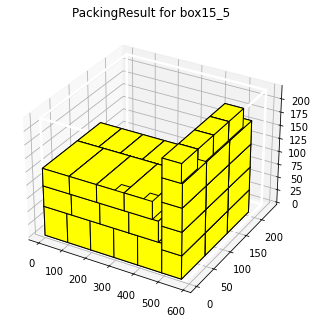

箱体的绝对坐标： [[[0.0, 0.0, 0.0], [0.0, 96.0, 0.0], [98.0, 0.0, 0.0], [98.0, 96.0, 0.0], [196.0, 0.0, 0.0], [196.0, 96.0, 0.0], [294.0, 0.0, 0.0], [294.0, 96.0, 0.0], [392.0, 0.0, 0.0], [392.0, 96.0, 0.0]], [[0.0, 0.0, 56.0], [0.0, 59.0, 56.0], [0.0, 118.0, 56.0], [119.0, 0.0, 56.0], [119.0, 59.0, 56.0], [119.0, 118.0, 56.0], [238.0, 0.0, 56.0], [238.0, 59.0, 56.0], [238.0, 118.0, 56.0], [357.0, 0.0, 56.0], [357.0, 59.0, 56.0], [357.0, 118.0, 56.0]], [[0.0, 0.0, 95.0], [113.0, 0.0, 95.0], [226.0, 0.0, 95.0], [339.0, 0.0, 95.0]], [[0.0, 92.0, 95.0], [92.0, 92.0, 95.0], [184.0, 92.0, 95.0], [276.0, 92.0, 95.0], [368.0, 92.0, 95.0]], [[490.0, 0.0, 0.0], [490.0, 0.0, 44.0], [490.0, 0.0, 88.0], [490.0, 0.0, 132.0], [490.0, 68.0, 0.0], [490.0, 68.0, 44.0], [490.0, 68.0, 88.0], [490.0, 68.0, 132.0], [490.0, 136.0, 0.0], [490.0, 136.0, 44.0], [490.0, 136.0, 88.0], [490.0, 136.0, 132.0]], [[490.0, 0.0, 176.0], [490.0, 45.0, 176.0], [490.0, 90.0, 176.0], [490.0, 135.0, 176.0]]]


In [16]:
main()